# K-prototypes

In [ ]:
pip install kmodes

In [ ]:
pip install plotnine

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from persiantools.jdatetime import JalaliDate
from persiantools.jdatetime import JalaliDateTime
import datetime, pytz
import math
from kmodes.kprototypes import KPrototypes

# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
from plotnine import *
import plotnine


# Reading the Data

In [3]:
data = pd.read_excel("/media/sda6/Projects/Data Mining on gas Network/output.xls",dtype={'TOF':"category", 'AF':"category",
       'DS':"category", 'feeder':"category",'TOP':"category", 'Relay':"category", 'COB':"category", 'PD':"category",
       'COP':"category","DOFDB":"float64"}).drop('BN',axis=1)

In [4]:
time=list()
for i in data['DFB']:
    i=i.split()
    yeardaymonth=i[0].split("/")
    hourandminute=i[1].split(":")
    time.append(JalaliDateTime(int(yeardaymonth[0]),int(yeardaymonth[1]),int(yeardaymonth[2]),int(hourandminute[0]),int(hourandminute[1])).to_gregorian())
data['DFB']=time

In [5]:
time=list()
for i in data['CFB']:
    try:
        i=i.split()
        yeardaymonth=i[0].split("/")
        hourandminute=i[1].split(":")
        time.append(JalaliDateTime(int(yeardaymonth[0]),int(yeardaymonth[1]),int(yeardaymonth[2]),int(hourandminute[0]),int(hourandminute[1])).to_gregorian())
    except:
        time.append(float("NaN"))
data['CFB']=time

In [6]:
time=list()
for i in data['PS']:
    try:
        i=i.split()
        yeardaymonth=i[0].split("/")
        hourandminute=i[1].split(":")
        time.append(JalaliDateTime(int(yeardaymonth[0]),int(yeardaymonth[1]),int(yeardaymonth[2]),int(hourandminute[0]),int(hourandminute[1])).to_gregorian())
    except:
        time.append(float("NaN"))
data['PS']=time

In [7]:
data=data[['feeder','DOFDB','EENS','RC','COB']]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   feeder  1649 non-null   category
 1   DOFDB   1649 non-null   float64 
 2   EENS    1649 non-null   float64 
 3   RC      1649 non-null   float64 
 4   COB     1649 non-null   category
dtypes: category(2), float64(3)
memory usage: 43.5 KB


In [9]:
data.isna().sum()

feeder    0
DOFDB     0
EENS      0
RC        0
COB       0
dtype: int64

In [10]:
# Get the position of categorical columns
catColumnsPos = [data.columns.get_loc(col) for col in list(data.select_dtypes('category').columns)]
print('Categorical columns           : {}'.format(list(data.select_dtypes('category').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['feeder', 'COB']
Categorical columns position  : [0, 4]


# K Prototype

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


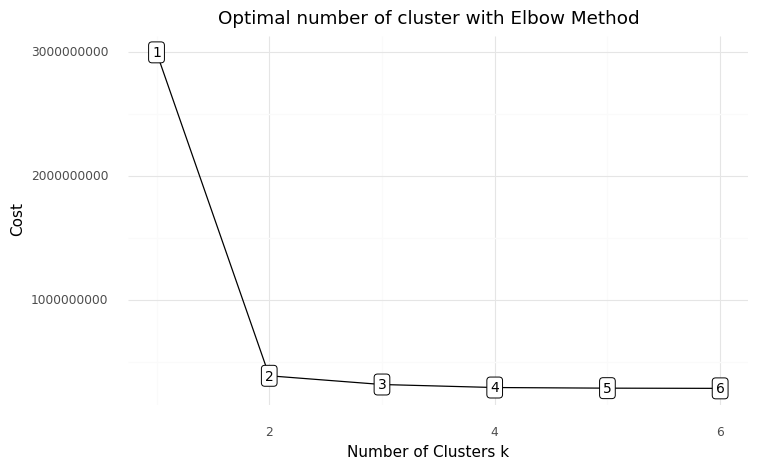

<ggplot: (8770442941919)>

In [93]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang')
        kprototype.fit_predict(data, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, len(cost)+1), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [11]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang')
kprototype.fit_predict(data, categorical = catColumnsPos)

array([2, 2, 2, ..., 2, 2, 2], dtype=uint16)

In [12]:
kprototype.cluster_centroids_

array([['36174.0', '0.01172791243158712', '0.01774193548387043', 'H',
        'D'],
       ['4238.25', '0.21657544956997618', '0.3427419354838696', 'I', 'D'],
       ['41.31771150334753', '0.05744464277811381',
        '0.25117521057075026', 'D', 'A']], dtype='<U32')

In [13]:
# Add the cluster to the dataframe
data['Cluster Labels'] = kprototype.labels_
data['Segment'] = data['Cluster Labels'].map({0:'First', 1:'Second',2:'Third'})
# Order the cluster
data['Segment'] = data['Segment'].astype('category')
data['Segment'] = data['Segment'].cat.reorder_categories(['First','Second','Third'])

In [14]:
# Cluster interpretation
'feeder','DOFDB','EENS','RC','COB'
data.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
data.groupby('Segment').agg(
    {
        'Total':'count',
        'feeder': lambda x: x.value_counts().index[0],
        'COB': lambda x: x.value_counts().index[0],
        'DOFDB': 'mean',
        'EENS': 'mean',
        'RC': 'mean'
    }
).reset_index()

,Segment,Total,feeder,COB,DOFDB,EENS,RC
0,First,2,H,W,36174.000000,0.011728,0.017742
1,Second,4,I,D,4238.250000,0.216575,0.342742
2,Third,1643,D,A,41.317712,0.057445,0.251175


# 

In [15]:
#ATTENTION : Second May be Change in Every run
data=data[data.Segment=="Third"].drop(["Total","Segment"],axis=1)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8


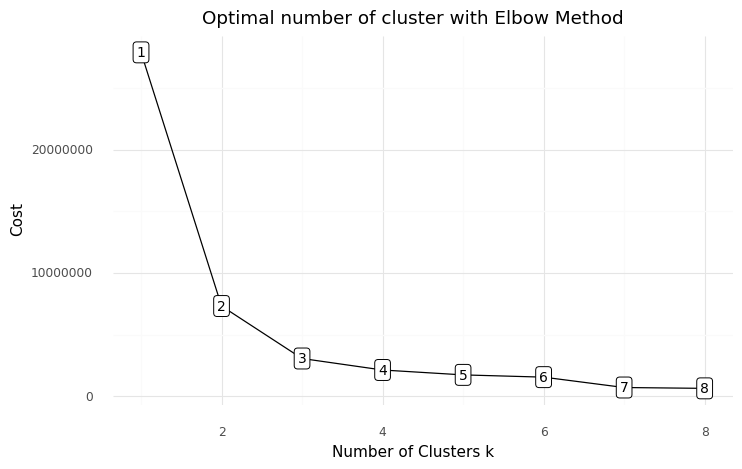

<ggplot: (8734250329423)>

In [16]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang')
        kprototype.fit_predict(data, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, len(cost)+1), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [18]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang')
kprototype.fit_predict(data, categorical = catColumnsPos)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [19]:
kprototype.cluster_centroids_

array([['16.84388995521433', '0.05508492169136051', '0.2530556828266577',
        'D', 'A'],
       ['371.672131147541', '0.09691229059588176', '0.20571126388154543',
        'A', 'D'],
       ['994.0', '0.124850829183984', '0.2424448217317481', 'A', 'S']],
      dtype='<U32')

In [20]:
# Add the cluster to the dataframe
data['Cluster Labels'] = kprototype.labels_
data['Segment'] = data['Cluster Labels'].map({0:'First', 1:'Second',2:'Third'})
# Order the cluster
data['Segment'] = data['Segment'].astype('category')
data['Segment'] = data['Segment'].cat.reorder_categories(['First','Second','Third'])

In [21]:
# Cluster interpretation
'feeder','DOFDB','EENS','RC','COB'
data.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
data.groupby('Segment').agg(
    {
        'Total':'count',
        'feeder': lambda x: x.value_counts().index[0],
        'COB': lambda x: x.value_counts().index[0],
        'DOFDB': 'mean',
        'EENS': 'mean',
        'RC': 'mean'
    }
).reset_index()

,Segment,Total,feeder,COB,DOFDB,EENS,RC
0,First,1563,D,A,16.843890,0.055085,0.253056
1,Second,61,A,D,371.672131,0.096912,0.205711
2,Third,19,A,S,994.000000,0.124851,0.242445
